<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
response

<Response [200]>

In [4]:
# json文字列をdictへ
j_res = json.loads(response.text)
j_res.keys()

dict_keys(['contacts', 'querents', 'patients', 'patients_summary', 'discharges_summary', 'inspections_summary', 'inspection_persons', 'inspection_status_summary', 'lastUpdate', 'main_summary'])

In [5]:
# データフレームにセット
df = pd.DataFrame(j_res)

In [6]:
# `patients_summary`
df.patients_summary.data[-10:]

[{'小計': 266, '日付': '2020-07-28T08:00:00.000Z'},
 {'小計': 250, '日付': '2020-07-29T08:00:00.000Z'},
 {'小計': 367, '日付': '2020-07-30T08:00:00.000Z'},
 {'小計': 463, '日付': '2020-07-31T08:00:00.000Z'},
 {'小計': 472, '日付': '2020-08-01T08:00:00.000Z'},
 {'小計': 292, '日付': '2020-08-02T08:00:00.000Z'},
 {'小計': 258, '日付': '2020-08-03T08:00:00.000Z'},
 {'小計': 309, '日付': '2020-08-04T08:00:00.000Z'},
 {'小計': 263, '日付': '2020-08-05T08:00:00.000Z'},
 {'小計': 360, '日付': '2020-08-06T08:00:00.000Z'}]

In [7]:
# `patients_summary` の `data` を抽出しデータフレームにセット
sub_df = pd.DataFrame(df.patients_summary.data)
sub_df.tail()

,日付,小計
191,2020-08-02T08:00:00.000Z,292
192,2020-08-03T08:00:00.000Z,258
193,2020-08-04T08:00:00.000Z,309
194,2020-08-05T08:00:00.000Z,263
195,2020-08-06T08:00:00.000Z,360


In [8]:
# 日付型の列を追加
#sub_df['datetime.date'] = [datetime.datetime.fromisoformat(str.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo')) for str in sub_df['日付']]
# for ~Python3.6(Google Colab)
sub_df['datetime.date'] = [datetime.datetime.strptime(str.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo')) for str in sub_df['日付']]
sub_df.tail()

,日付,小計,datetime.date
191,2020-08-02T08:00:00.000Z,292,2020-08-02 17:00:00+09:00
192,2020-08-03T08:00:00.000Z,258,2020-08-03 17:00:00+09:00
193,2020-08-04T08:00:00.000Z,309,2020-08-04 17:00:00+09:00
194,2020-08-05T08:00:00.000Z,263,2020-08-05 17:00:00+09:00
195,2020-08-06T08:00:00.000Z,360,2020-08-06 17:00:00+09:00


In [9]:
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
sub_df['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in sub_df['datetime.date']]
sub_df.tail()

,日付,小計,datetime.date,week_num
191,2020-08-02T08:00:00.000Z,292,2020-08-02 17:00:00+09:00,'20w31
192,2020-08-03T08:00:00.000Z,258,2020-08-03 17:00:00+09:00,'20w32
193,2020-08-04T08:00:00.000Z,309,2020-08-04 17:00:00+09:00,'20w32
194,2020-08-05T08:00:00.000Z,263,2020-08-05 17:00:00+09:00,'20w32
195,2020-08-06T08:00:00.000Z,360,2020-08-06 17:00:00+09:00,'20w32


In [10]:
# 曜日の列をセット
sub_df['week_day'] = [d.strftime('%a') for d in sub_df['datetime.date']]
sub_df.tail(15)

,日付,小計,datetime.date,week_num,week_day
181,2020-07-23T08:00:00.000Z,366,2020-07-23 17:00:00+09:00,'20w30,Thu
182,2020-07-24T08:00:00.000Z,260,2020-07-24 17:00:00+09:00,'20w30,Fri
183,2020-07-25T08:00:00.000Z,295,2020-07-25 17:00:00+09:00,'20w30,Sat
184,2020-07-26T08:00:00.000Z,239,2020-07-26 17:00:00+09:00,'20w30,Sun
185,2020-07-27T08:00:00.000Z,131,2020-07-27 17:00:00+09:00,'20w31,Mon
186,2020-07-28T08:00:00.000Z,266,2020-07-28 17:00:00+09:00,'20w31,Tue
187,2020-07-29T08:00:00.000Z,250,2020-07-29 17:00:00+09:00,'20w31,Wed
188,2020-07-30T08:00:00.000Z,367,2020-07-30 17:00:00+09:00,'20w31,Thu
189,2020-07-31T08:00:00.000Z,463,2020-07-31 17:00:00+09:00,'20w31,Fri
190,2020-08-01T08:00:00.000Z,472,2020-08-01 17:00:00+09:00,'20w31,Sat


In [11]:
# 週毎に集計
groupby_week_num = sub_df.groupby('week_num')
groupby_week_num

In [12]:
# 集計結果から平均と合計を取得しデータフレームにセット
week_num_df = pd.DataFrame({
    'week_num': sub_df['week_num'].unique(),
    'mean': [m for m in groupby_week_num.agg({'小計': 'mean'})['小計']], 
    'sum': [s for s in groupby_week_num.agg({'小計': 'sum'})['小計']]
})
week_num_df.tail()

,week_num,mean,sum
24,'20w28,166.000000,1162
25,'20w29,212.000000,1484
26,'20w30,257.571429,1803
27,'20w31,320.142857,2241
28,'20w32,297.500000,1190


### グラフ出力

In [13]:
### 日毎の数
x = sub_df['datetime.date']
y = sub_df['小計']

In [14]:
### 週毎の数
x2 = week_num_df['week_num']
y2_1 = week_num_df['mean']
y2_2 = week_num_df['sum']

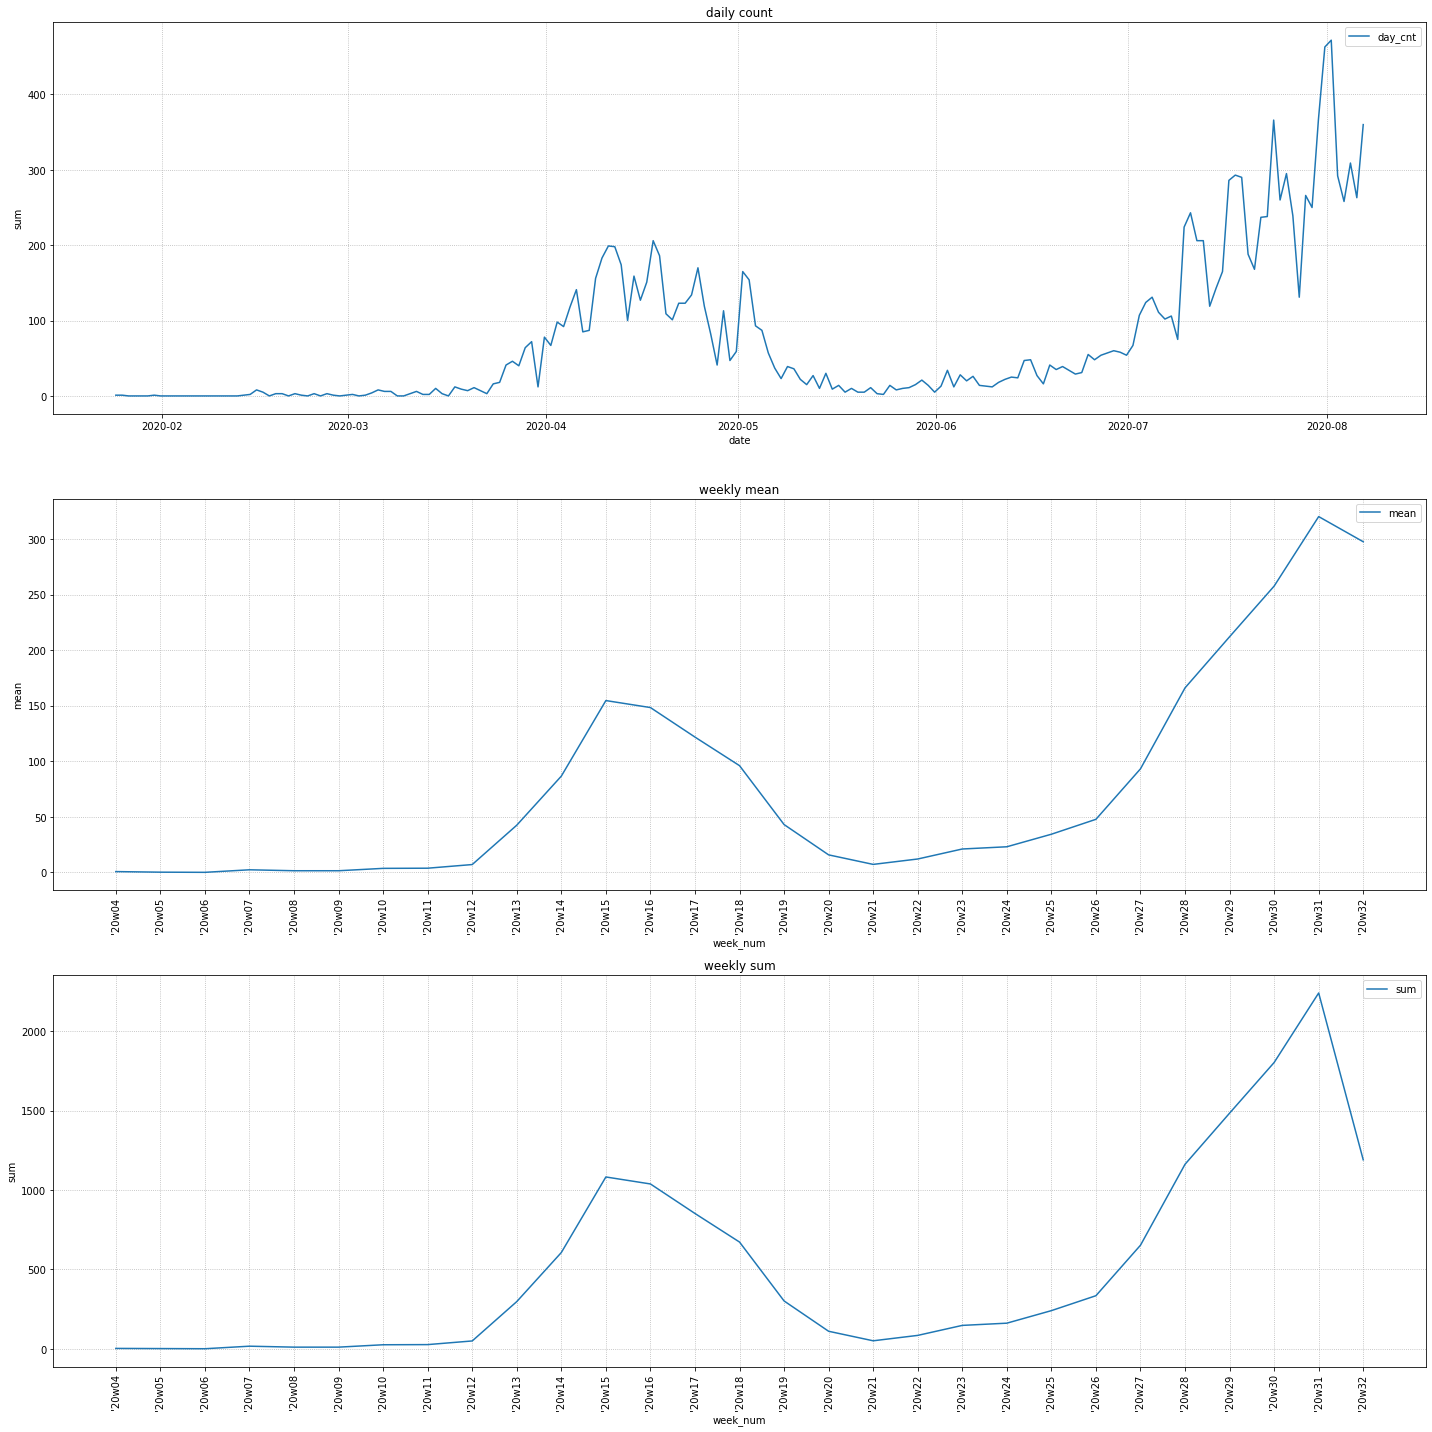

In [15]:
fig, ax = plt.subplots(3, 1, figsize=(20, 20))

### 日毎の数
ax[0].set_title('daily count')
ax[0].set_xlabel('date')
ax[0].set_ylabel('sum')
ax[0].plot(x, y, label='day_cnt')
ax[0].grid(linestyle=':')
ax[0].legend()

### 週毎の平均
ax[1].set_title('weekly mean')
ax[1].set_xticklabels(labels=x2, rotation=90)
ax[1].set_xlabel('week_num')
ax[1].set_ylabel('mean')
ax[1].plot(x2, y2_1, label='mean')
ax[1].grid(linestyle=':')
ax[1].legend()

### 週毎の合計
ax[2].set_title('weekly sum')
ax[2].set_xticklabels(labels=x2, rotation=90)
ax[2].set_xlabel('week_num')
ax[2].set_ylabel('sum')
ax[2].plot(x2, y2_2, label='sum')
ax[2].grid(linestyle=':')
ax[2].legend()

plt.tight_layout()

---

In [16]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23567 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35336 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 23567 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 35336 missing from current font.
  font.set_text(s, 0, flags=flags)


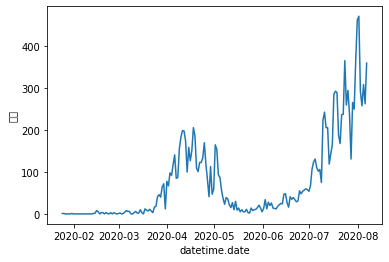

In [17]:
sns.lineplot(x='datetime.date', y='小計', data=sub_df)

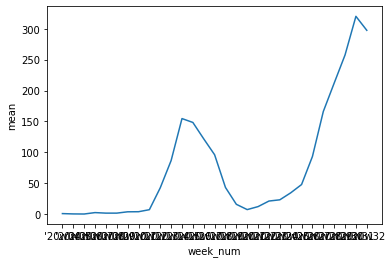

In [18]:
sns.lineplot(x='week_num', y='mean', data=week_num_df)

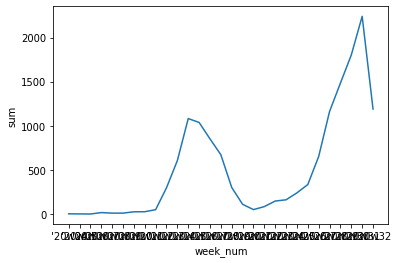

In [19]:
sns.lineplot(x='week_num', y='sum', data=week_num_df)